Pedro Daia Cardoso - Image Regression 

In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.all import *

     |████████████████████████████████| 719 kB 33.6 MB/s 
     |████████████████████████████████| 365 kB 10.9 MB/s 
     |████████████████████████████████| 4.7 MB 55.4 MB/s 
     |████████████████████████████████| 1.2 MB 67.9 MB/s 
     |████████████████████████████████| 101 kB 11.7 MB/s 
     |████████████████████████████████| 212 kB 73.3 MB/s 
     |████████████████████████████████| 141 kB 58.6 MB/s 
     |████████████████████████████████| 115 kB 76.9 MB/s 
     |████████████████████████████████| 596 kB 56.8 MB/s 
     |████████████████████████████████| 127 kB 64.7 MB/s 
     |████████████████████████████████| 6.6 MB 57.8 MB/s 
Mounted at /content/gdrive


Image Regression - treinar um dataset em que a independent var (x) é imagem, e a dependent var (y) é um ou mais floats.

Objetivo: fazer um key point model -> identificar um ponto específico em uma imagem, neste caso, vamos procurar o centro de rostos de pessoas.

In [2]:
path = untar_data(URLs.BIWI_HEAD_POSE)
Path.BASE_PATH = path

path.ls()

(#50) [Path('03.obj'),Path('22'),Path('19.obj'),Path('14.obj'),Path('18'),Path('04'),Path('13.obj'),Path('02.obj'),Path('04.obj'),Path('21')...]

In [3]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

`"path/##/frame_####_(pose | rgb).(txt | jpg)"`

In [4]:
img_files = get_image_files(path)
img_files

(#15678) [Path('22/frame_00292_rgb.jpg'),Path('22/frame_00258_rgb.jpg'),Path('22/frame_00328_rgb.jpg'),Path('22/frame_00214_rgb.jpg'),Path('22/frame_00233_rgb.jpg'),Path('22/frame_00257_rgb.jpg'),Path('22/frame_00580_rgb.jpg'),Path('22/frame_00342_rgb.jpg'),Path('22/frame_00231_rgb.jpg'),Path('22/frame_00520_rgb.jpg')...]

In [5]:
im = PILImage.create(img_files[1])
im.shape

(480, 640)

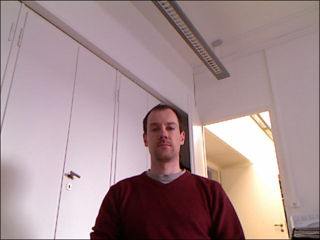

In [6]:
im.to_thumb(320)

Agora, o próprio site do dataset explica o formato da pose.txt files associada a cada imagem, que contem a localização do centro da cabeça em cada img. Como os detalhes deste cálculo não são importantes, aqui é a função desenvolvida por eles para achar o centro a partir do pose.txt:

In [7]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
def getCenter(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [8]:
getCenter(img_files[1])

tensor([345.5344, 262.4494])

Esse tensor são as coordenadas do centro do rosto na imagem.

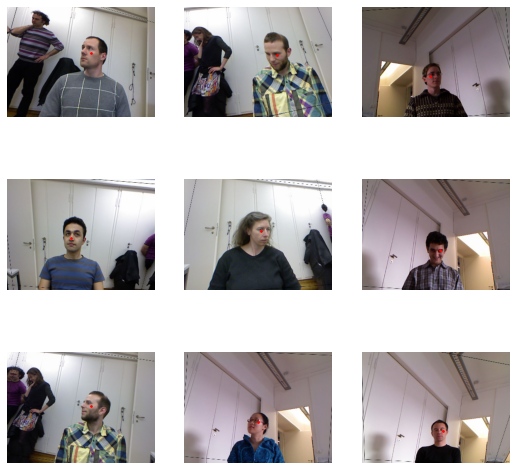

In [9]:
biwi_block = DataBlock(
    blocks = (ImageBlock, PointBlock),
    get_items = get_image_files,
    get_y = getCenter,
    splitter = FuncSplitter(lambda o: o.parent.name=='13'), # pegando uma pessoa aleatória (#13) para testar com pessoas diferentes, não só frames diferentes
    batch_tfms = [*aug_transforms(size=(240, 320)), # deixar do msm tamanho (reduzido) p/ eficiência
                  Normalize.from_stats(*imagenet_stats)]
)

# OBS sobre splitter: se usar o FuncSplitter, qnd a fç retorna True = validation, False = training

dls = biwi_block.dataloaders(path)
dls.show_batch()

In [10]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

o 3 no shape das imagens indica que temos 3 channels, i.e, 3 colors (RGB)

In [11]:
yb[0]

TensorPoint([[-0.1175, -0.2533]], device='cuda:0')

Agora vamos criar um learner p/ o dls, utilizando um y_range: p/ indicar ao fastai o range que iremos trabalhar para nossas targets, comum em problemas de regression. O fastai costuma a utilizar [-1,1] como range para coordenadas, então trabalharemos neste range.

In [12]:
learn = vision_learner(dls, resnet18, y_range=(-1,1))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Como não especificamos a loss func, o fastai escolhe para nós. No exemplo de Multi-Label classification, onde no learner passavamos um MultiCategoryBlock, o fastai identificava que precisavamos usar uma compátivel, que era a nn.BCEWithLogitsLoss. Vamos ver qual a que foi escolhida agora:

In [13]:
dls.loss_func

FlattenedLoss of MSELoss()

Vamos agora analisar a learning rate:

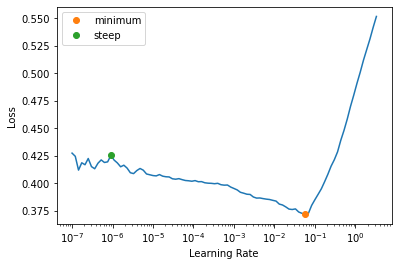

In [14]:
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

A partir de 1e-1 o aumento da LR piora o loss, então vamos de 2e-2 por exemplo.

In [15]:
lr = 2e-2
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,time
0,0.046749,0.038051,02:00
1,0.006958,0.002267,01:58
2,0.003235,0.001259,01:58
3,0.002115,0.000982,02:00
4,0.001684,0.000453,01:58


Vamos agora, por fim, ver os resultados. Coluna da direita é nossas predictions, da esquerda são as coordenadas corretas.

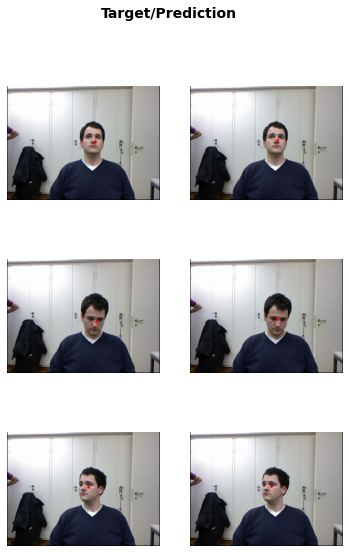

In [17]:
learn.show_results(max_n=3)